In [1]:
# 导入pandas相关的工具包
import numpy as np 
import pandas as pd 
import matplotlib as plt

dpath = "./"
Train = pd.read_csv(dpath+"Train.csv")
Test = pd.read_csv(dpath+"Test.csv")

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# 剔除Train和Test缺失值
Train = Train.drop(["LoggedIn", "Interest_Rate", "Processing_Fee", 
"EMI_Loan_Submitted","Loan_Amount_Submitted", "Loan_Tenure_Submitted"], axis=1)
Test = Test.drop(["Interest_Rate", "Processing_Fee", "EMI_Loan_Submitted",
"Loan_Amount_Submitted", "Loan_Tenure_Submitted"], axis=1)

In [3]:
# 删除数量较少的缺失值
willDrop = ["City", "Loan_Amount_Applied", "Loan_Tenure_Applied", 
"Employer_Name", "Var1"]
Train = Train.dropna(subset = willDrop)
Test = Test.dropna(subset = willDrop)

In [4]:
# 填充Salary_Account中的null值
Train['Salary_Account'] = Train['Salary_Account'].fillna('unknown')
Test["Salary_Account"] = Test["Salary_Account"].fillna("unknown")
X_train = Train.drop(["Disbursed"], axis = 1)
y_train = Train["Disbursed"]

# 训练数据

In [5]:
# 导入LabelEncoder和LGBM的工具包
import lightgbm as lgbm 
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [6]:
# 将所有参数转化为数值
# 将test拼接到train里，然后统一labelencoder
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

willLE = ["ID", "Gender", "City", "DOB", "Lead_Creation_Date", "Employer_Name", "Var2", 
"Salary_Account", "Mobile_Verified", "Var1", "Var5", "Filled_Form", "Device_Type", "Source"]
for col in willLE:
    colLabEn = LE.fit(X_train[col].append(Test[col]).astype(str))
    X_train[col] = colLabEn.transform(X_train[col].astype(str))
    Test[col] = colLabEn.transform(Test[col].astype(str))
print("Transform successful!")

Transform successful!


In [7]:
'''
# 将所有数据归一化处理
X_train_cols = X_train.columns
Test_cols = Test.columns

from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()

X_train = ms.fit_transform(X_train)
Test = ms.fit_transform(Test)
X_train = pd.DataFrame(columns = X_train_cols, data = X_train)
Test = pd.DataFrame(columns = Test_cols, data = Test)
'''

'\n# 将所有数据归一化处理\nX_train_cols = X_train.columns\nTest_cols = Test.columns\n\nfrom sklearn.preprocessing import MinMaxScaler\nms = MinMaxScaler()\n\nX_train = ms.fit_transform(X_train)\nTest = ms.fit_transform(Test)\nX_train = pd.DataFrame(columns = X_train_cols, data = X_train)\nTest = pd.DataFrame(columns = Test_cols, data = Test)\n'

# LightGBM参数调优
LightGBM的主要的超参数包括  
1. 树的数目n_estimators和学习率learning_rate
2. 树的最大深度max_depth和树的最大叶子节点数目num_leaves(注意:XGboot只有max_depth,
LightGBM采用叶子优先的方式生成树，num_leaves很重要，设置成比2^max_depth小)
3. 叶子节点的最小样本数:min_data_in_leaf(min_data, min_child_samples)
4. 每颗数的列采样比例:feature_fraction/colsample_bytree
5. 每棵树的行采样比例:bagging_fraction(需要同时设置bagging_freq=1)/subsample
6. 正则化参数lambda_l1(reg_alpha),lambda_l2(reg_lambda)
7. 两个模型复杂度参数，但会影响模型速度和精度。可根据特征取值范围和样本数目修改这两个参数
1) 特征的最大bin数目max_bin:默认255
2) 用来建立直方图的样本数目subsample_for_bin:默认200000  
对n_estimators，用LightGBM内嵌的cv函数调优，因为同XGBoost一样，LightGBM学习过程内嵌了
cv，速度极快。对其他参数用GridSearchCV

# nestimators

In [8]:
# 计算参数对应的得分并求出初步的nestimators
MAX_ROUNDS = 10000
def get_n_estimators(params, X_train, y_train, early_stopping_rounds=10):
    lgbm_param = params.copy()
    lgbmtrain = lgbm.Dataset(X_train, y_train)
    cv_result = lgbm.cv(lgbm_param, lgbmtrain, num_boost_round=MAX_ROUNDS, nfold=3, metrics="binary_logloss", 
    early_stopping_rounds=early_stopping_rounds, seed=3)
    print("best n_estimators:", len(cv_result["binary_logloss-mean"]))
    print("best cv score:", cv_result["binary_logloss-mean"][-1])
    
    return len(cv_result["binary_logloss-mean"])

In [9]:
# 输入参数
params = {"boosting_type":"gbdt", "objective":"binary", "n_jobs":8, "learning_rate":0.1, 
"num_leaves":60, "max_depth":6, "max_bin":127, "subsample":0.7, "bagging_freq":1, "colsample_bytree":0.7}

n_estimators_1 = get_n_estimators(params, X_train, y_train)

best n_estimators: 43
best cv score: 0.06506876345663988


In [10]:
# num_leaves&max_depth = 7
# num_leaves建10~60，值越大模型越复杂，越容易过拟合响应的扩大max_depth=7
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

params = {"boosting_type":"gbdt", "objective":"binary",
"n_jobs":8, "learning_rate":0.1, "n_estimators":n_estimators_1, "max_depth":7,
"max_bin":127, "subsample":0.7, "bagging_freq":1, "colsample_bytree":0.7}
# silent是否在boosting过程中输出
lg = LGBMClassifier(silent=False, **params)

num_leaves_s = range(10, 60, 10)
tuned_parameters = dict(num_leaves = num_leaves_s)

grid_search = GridSearchCV(lg, n_jobs=4, param_grid=tuned_parameters, cv=kfold, 
scoring="neg_log_loss", verbose=5, refit=False)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:    5.9s remaining:    1.4s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    6.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=7, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=43,
        n_jobs=8, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'num_leaves': range(10, 60, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


0.06494520931307951
{'num_leaves': 30}


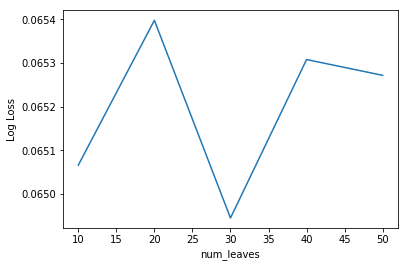

In [11]:
# 显示最终合适得num_leaves(30)
print(-grid_search.best_score_)
print(grid_search.best_params_)
test_means = grid_search.cv_results_["mean_test_score"]
test_stds = grid_search.cv_results_["std_test_score"]
train_means = grid_search.cv_results_["mean_train_score"]
train_stds = grid_search.cv_results_["std_train_score"]

n_leafs = len(num_leaves_s)
X_axis = num_leaves_s
plt.plot(X_axis, -test_means)

plt.xlabel("num_leaves")
plt.ylabel("Log Loss")
plt.show()

叶子节点的最小样本数目  
叶子节点数目:30,共2类，平均每类40个叶子节点  
每棵树的样本数目最少的类(稀有事件)的样本数目:5000(最小样本数目)*2/3(3折交叉验证)*0.7(subsample)=2333
所以每个叶子节点2300/30 = 70个样本点
搜索范围 10~100

In [12]:
# 调整min_child_sample的参数(100)
params = {"boosting_type":"gbdt", "objective":"binary", "num_leaves":30, 
        "n_jobs":8, "learning_rate":0.1, "n_estimators":n_estimators_1, "max_depth":7,
        "max_bin":127, "subsample":0.7, "bagging_freq":1, "colsample_bytree":0.7}

lg = LGBMClassifier(silent=False, **params)
min_child_samples = range(60, 130, 10)
tuned_parameters = dict(min_child_samples=min_child_samples)

grid_search = GridSearchCV(lg, n_jobs=8, param_grid=tuned_parameters, cv = kfold,
                           scoring='neg_log_loss', verbose=5, refit=False)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  11 out of  21 | elapsed:    6.9s remaining:    6.3s
[Parallel(n_jobs=8)]: Done  16 out of  21 | elapsed:    8.3s remaining:    2.5s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  21 out of  21 | elapsed:    9.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=7, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=43,
        n_jobs=8, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'min_child_samples': range(60, 130, 10)},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

0.06440778436266455
{'min_child_samples': 100}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


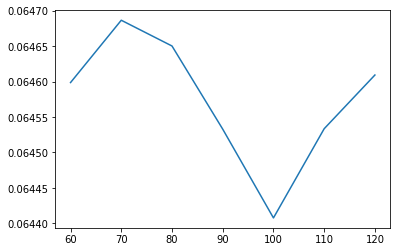

In [13]:
# 显示min_child_sample cv误差曲线
print(-grid_search.best_score_)
print(grid_search.best_params_)

test_means = grid_search.cv_results_["mean_test_score"]
test_stds = grid_search.cv_results_["std_test_score"]
train_means = grid_search.cv_results_["mean_train_score"]
train_stds = grid_search.cv_results_["std_train_score"]

X_axis = min_child_samples
plt.plot(X_axis, -test_means)
plt.show()

In [14]:
# 调试参数sub_sample/bagging_fraction(0.7)
params = {"boosting_type":"gbdt", "objective":"binary", "num_leaves":30, 
        "n_jobs":8, "learning_rate":0.1, "n_estimators":n_estimators_1, "max_depth":7,
        "max_bin":127, "min_child_samples":100, "bagging_freq":1, "colsample_bytree":0.7}

lg = LGBMClassifier(silent=False, **params)
subsample_s = [i/10.0 for i in range(5,10)]
tuned_parameters = dict(subsample = subsample_s)

grid_search = GridSearchCV(lg, n_jobs=8, param_grid=tuned_parameters, cv=kfold,
                        scoring="neg_log_loss", verbose=5, refit=False)
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    2.1s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    3.0s remaining:    2.6s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    4.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    4.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=7, min_child_samples=100,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=43,
        n_jobs=8, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

0.06440778436266455
{'subsample': 0.7}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


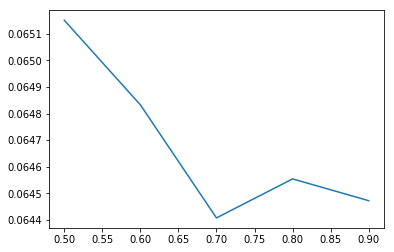

In [15]:
# 显示subsample cv的误差曲线
print(-grid_search.best_score_)
print(grid_search.best_params_)

test_means = grid_search.cv_results_["mean_test_score"]
test_stds = grid_search.cv_results_["std_test_score"]
train_means = grid_search.cv_results_["mean_train_score"]
train_stds = grid_search.cv_results_["std_train_score"]

X_axis = subsample_s
plt.plot(X_axis, -test_means)
plt.show()

In [16]:
# 调试参数sub_feature/feature_fraction/colsample_bytree(0.7)
params = {"boosting_type":"gbdt", "objective":"binary", "num_leaves":30, 
        "n_jobs":8, "learning_rate":0.1, "n_estimators":n_estimators_1, "max_depth":7,
        "max_bin":127, "min_child_samples":100, "bagging_freq":1, "subsample":0.7}

lg = LGBMClassifier(silent=False, **params)
colsample_bytree = [i/10.0 for i in range(5, 10)]
tuned_parameters = dict(colsample_bytree=colsample_bytree)

grid_search = GridSearchCV(lg, n_jobs=8, param_grid=tuned_parameters, cv=kfold,
                        scoring="neg_log_loss", verbose=5, refit=False)
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:    1.8s remaining:    5.2s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:    4.2s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    4.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_bin=127, max_depth=7, min_child_samples=100,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=43,
        n_jobs=8, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

0.06440778436266455
{'colsample_bytree': 0.7}


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


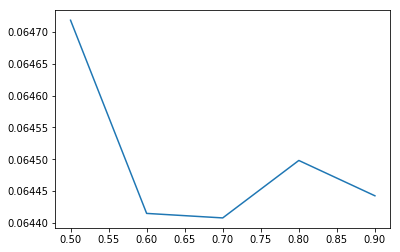

In [17]:
print(-grid_search.best_score_)
print(grid_search.best_params_)

test_means = grid_search.cv_results_[ 'mean_test_score' ]
test_stds = grid_search.cv_results_[ 'std_test_score' ]
train_means = grid_search.cv_results_[ 'mean_train_score' ]
train_stds = grid_search.cv_results_[ 'std_train_score' ]

x_axis = colsample_bytree
plt.plot(x_axis, -test_means)
plt.show()

In [18]:
# 减少学习率，调整n_estimators
params = {"boosting_type":"gbdt", "objective":"binary", "num_leaves":30, 
        "n_jobs":8, "learning_rate":0.01,  "max_depth":7, #'n_estimators':n_estimators_1,
        "max_bin":127, "min_child_samples":100, "bagging_freq":1, "subsample":0.7}

n_estimators_2 = get_n_estimators(params , X_train , y_train)

best n_estimators: 403
best cv score: 0.06382328101618401


In [19]:
params = {"boosting_type":"gbdt", "objective":"binary", "num_leaves":30, 
        "n_jobs":8, "learning_rate":0.01,  "max_depth":7, 'n_estimators':n_estimators_2,
        "max_bin":127, "min_child_samples":100, "bagging_freq":1, "subsample":0.7}

lg = LGBMClassifier(silent=False,  **params)
lg.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_bin=127, max_depth=7, min_child_samples=100,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=403,
        n_jobs=8, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=False, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=0)

In [20]:
# 存储特征
import pickle
pickle.dump(lg, open(dpath+"HappyBank_LGBM.pkl", "wb"))
pickle.dump(LE, open(dpath+"HappyBank_LabEn.pkl", "wb"))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Series.data is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


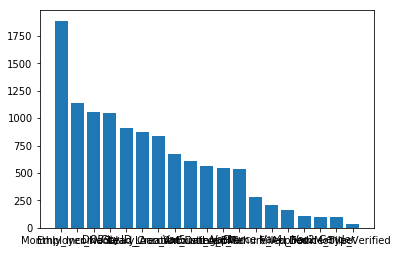

<Figure size 936x432 with 0 Axes>

In [21]:
# 输出特征重要性
# 使用pd.Series进行组合，值是特征重要性的值，index是样本特征，.sort_value 进行排序操作
feature_important = pd.Series(lg.feature_importances_, index = X_train.columns).sort_values(ascending=False)
plt.bar(feature_important.index, feature_important.data)
plt.figure(figsize=(13, 6))
plt.show()